# Face Expression Classification

---



## Introduction

Author : Hafidzati Hikmadani <br>

## Dataset

The dataset is contain a collection of thousands face expression in grayscale format. Each picture has been classified into 7 labels of expression :
1. angry
2. disgust
3. fear
4. happy
5. neutral
6. sad
7. surprise

More over, the author of dataset also has been divided each picture into training and validation dataset in folder form.

You could download the dataset [here](https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset)

## Goals

Goals of this notebook is creating computer vision model to detect face expression from human face image. Author will comparing the model between vanilla approach and transfer learning approach using feature vectors from pre-trained model VGG19.



## Import Library

In [1]:
#Import Library
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array , load_img, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import vgg19

In [2]:
#Test GPU (optional if you had GPU)
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

print(tf.__version__)

Please install GPU version of TF
2.6.0


## Data Loading

Recalling dataset description before, we have 2 folder of images containing train and validation images. Let's check total images we have.

In [2]:
#Define path folder dataset
TRAIN_PATH = "dataset/train"
VALID_PATH = "dataset/validation"

In [3]:
#Calculate total data in folder

def total_data (path):
  data_dir = pathlib.Path(path)
  image_count = len(list(data_dir.glob('*/*.jpg')))
  text = "Total images in {} : {} ".format(path,image_count)
  return text
  

print(total_data(TRAIN_PATH))
print(total_data(VALID_PATH))

Total images in dataset/train : 28821 
Total images in dataset/validation : 7066 


From above result, we have 28.821 images of training dataset and 7.066 images of validation dataset. These number seems needs high computational. Since author has limitation in computational, so we deciced to only use few class label (happy and sad) and decrease the total of image to be processed.

We will split train folder into train and validation data again with label happy and sad only.

## Data Cleaning

Since we have image data instead of tabular data, we dont do much cleaning. Our data has been organized well between its class and its train and validation dataset in folder.

Author also has take sample random data from the dataset and organize it in images folder. Here we will load the sample data for our project purpose.

In [135]:
#Define path folder dataset
DATASET_PATH= "images/train"

#Total dataset will be used
print(total_data(DATASET_PATH))

Total images in images/train : 9065 


Now we have 9.065 data to be processed for our project. We will split it again into validaton and training dataset in future.

## Data PreProcess (Input Pipeline)

In this section we will create a input preprocessing pipeline for our data. Our dataset will run through this process in our pipeline :
1. Collecting image dataset from path 
2. Split dataset into train and validation 
3. Set batch size for performance input
4. Set autotune to maximize input processing process
5. Get classes names of dataset images

In [136]:
#Define function input pipeline

def data_gather_preprocess(path, img_width, img_height, batch_size):

  #define training dataset
  train_ds = image_dataset_from_directory(
      path,
      shuffle=True,
      seed=42,
      batch_size=batch_size,
      image_size=(img_width, img_height),
      validation_split= 0.2,
      subset="training"
  )
  
  #define validation dataset
  valid_ds = image_dataset_from_directory(
      path,
      shuffle=True,
      seed=42,
      batch_size=batch_size,
      image_size=(img_width, img_height),
      validation_split= 0.2,
      subset="validation"
  )

  #return classname
  class_names = train_ds.class_names

  #Set performance process
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, valid_ds, class_names



In [139]:
#Generate dataset
X_train, X_valid, class_names = data_gather_preprocess(DATASET_PATH, 224,224,10)

Found 9065 files belonging to 2 classes.
Using 7252 files for training.
Found 9065 files belonging to 2 classes.
Using 1813 files for validation.


In [140]:
#Check class names 
class_names

['happy', 'sad']

From above dataset, we could see that we have 7.252 training dataset and 1.813 validation dataset. And also we have 2 class called happy and sad.

## Data Visualization

Now before we get to modeling, let's visualize some sample of our dataset images.

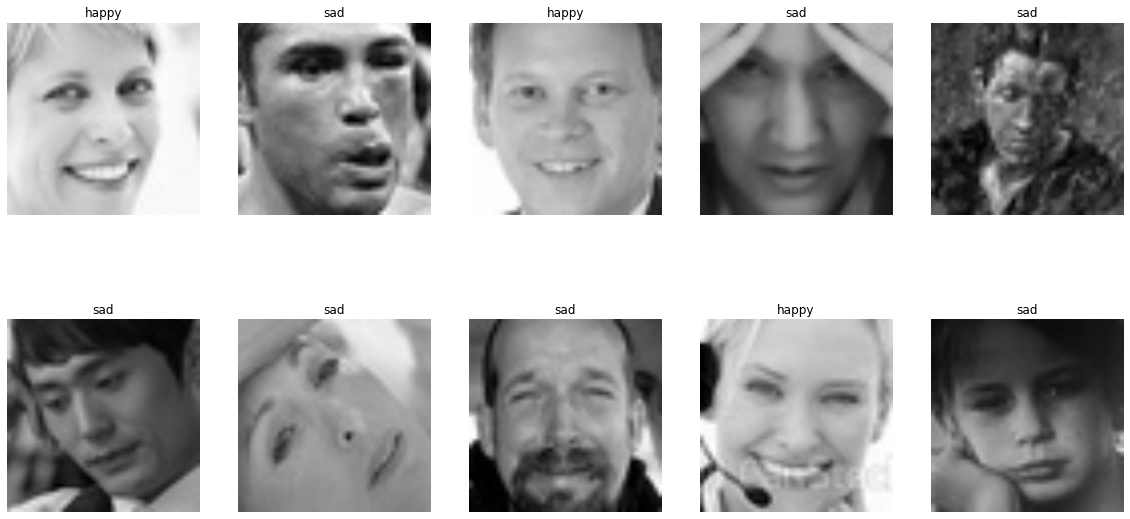

In [160]:
#visualize dataset
plt.figure(figsize=(20,10))

for images, labels in X_train.take(1):
  for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

We have dataset in grayscale form of images means we have 2D size. But in tensorflow with image_dataset_from_directory will turn 3D size of images. For grayscale case, they will return 3 channel of 3rd dimension with same value of each channel.

## Model Definition and Training

In this section we will try 3 experiments of prediction modeling :
1. We will create basic model of CNN with vanila approach
2. We will tunned our vanila basic model CNN
3. We will use transfer learning approach to create modeling

In [2]:
#Define input size of image
IMG_SIZE = (224,224)

### Basic model (Vanila)

In [ ]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In basic vanila model , we  will apply rescaling layer at first to scaling our dataset from maximal picture of 255 into values 0-1. Then since our dataset is in grayscale form while the model we will use especially for VGG19 is using RGB form, at input shape we will add third tuple to manage it.
<br><br>
Next, in at CNN section we will use 3 layers of Conv2D and 3 layer of Maxpooling with padding = same and activation function used are relu. While in classification section, we will add a flatten layer to convert 3D form into 1D array , 4 dense hidden layer with activation relu and one output layer with activation sigmoid since we only have 2 label , happy or sad.

In [3]:
## Build model ##

model1 = Sequential()
#CNN
model1.add(layers.Rescaling(1./255, input_shape=(IMG_SIZE + (3,))))
model1.add(layers.Conv2D(32,3, padding="same",activation="relu"))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(64,3, padding="same",activation="relu"))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(128,3, padding="same",activation="relu"))
model1.add(layers.MaxPooling2D())

#Classification
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation="relu"))
model1.add(layers.Dense(128,activation="relu"))
model1.add(layers.Dense(64,activation="relu"))
model1.add(layers.Dense(32,activation="relu"))
model1.add(layers.Dense(1, activation = "sigmoid"))

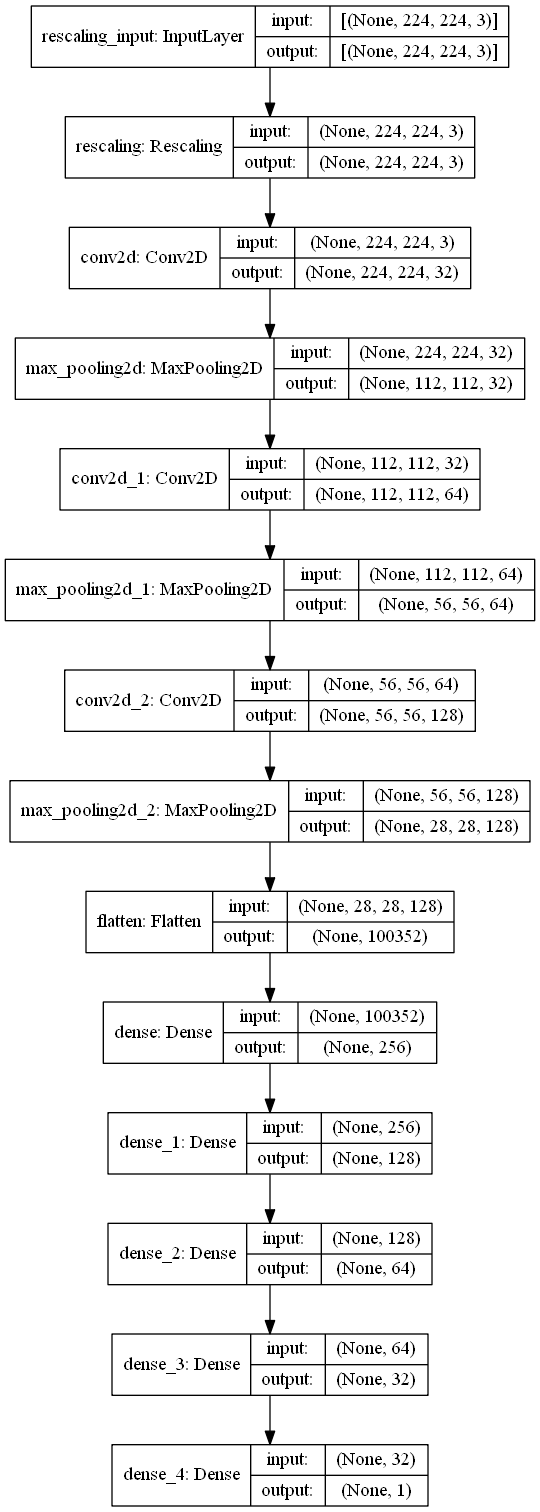

In [4]:
#show the result of architecture
keras.utils.plot_model(model1, show_shapes=True)

In [32]:
#model summary
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 128)      

At training process, we will saved the best model from epoch based on validation loss of each epoch to savedmodel format of tensorflow. So we need to define the model checkpoint below.
<br>
<br>

At model compiling, we will Adam optimizer and loss binary crossentropy since our label only has 2 class (happy or sad). For the metrics we will using a few evaluation metrics such as accuracy , AUC , Recall and Precision.

In [33]:
#Checkpoint definition
model1_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="./bestBasicModel",
    save_weights_only = False,
    monitor = "val_loss",
    save_best_only=True
    )

#model compile
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss= "binary_crossentropy" , metrics=["accuracy", "AUC","Recall","Precision"])

In model training, we will using 10 epoch for all of model.

In [34]:
#train mdoel
history1 = model1.fit(
    X_train,
    validation_data= X_valid,
    epochs=10,
    verbose=2,
    callbacks=[model1_cp]
    )

Epoch 1/10
726/726 - 404s - loss: 0.7745 - accuracy: 0.5405 - auc: 0.4844 - recall: 0.9746 - precision: 0.5431 - val_loss: 0.6884 - val_accuracy: 0.5494 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5494
INFO:tensorflow:Assets written to: .\bestBasicModel\assets
Epoch 2/10
726/726 - 443s - loss: 0.6902 - accuracy: 0.5436 - auc: 0.4884 - recall: 1.0000 - precision: 0.5436 - val_loss: 0.6883 - val_accuracy: 0.5494 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5494
INFO:tensorflow:Assets written to: .\bestBasicModel\assets
Epoch 3/10
726/726 - 433s - loss: 0.6897 - accuracy: 0.5436 - auc: 0.5016 - recall: 1.0000 - precision: 0.5436 - val_loss: 0.6889 - val_accuracy: 0.5494 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5494
Epoch 4/10
726/726 - 403s - loss: 0.6897 - accuracy: 0.5436 - auc: 0.5017 - recall: 1.0000 - precision: 0.5436 - val_loss: 0.6887 - val_accuracy: 0.5494 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5494
Epoch 5/10
726/726

Now below, we will check the evaluation or trend of our basic vanilla model per its each epoch.

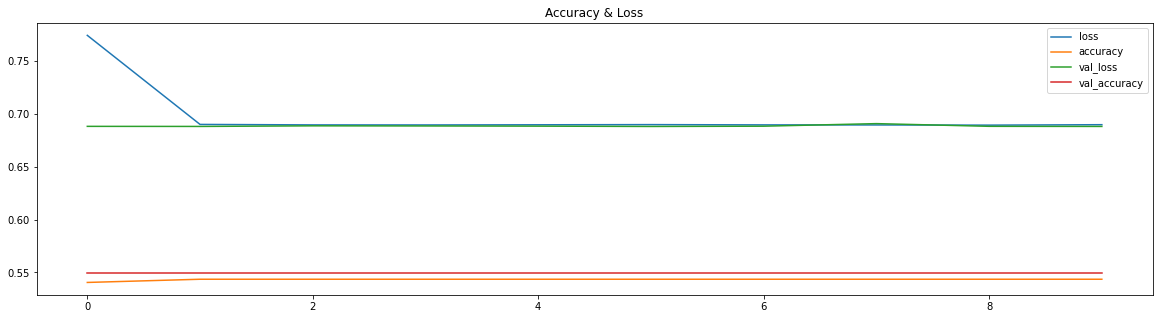

In [183]:
#Evaluation
hist1 = {k: history1.history[k] for k in ["loss","accuracy","val_loss","val_accuracy"]}

pd.DataFrame(hist1).plot(figsize=(20,5))
plt.title("Accuracy & Loss")
plt.show()

From above graph, we could see that vanilla basic of CNN model has higher validation loss than its validation accuracy. From overfit perspective, we could say this model is not overfit but it's perform bad. Eventhough the accuracy hit above 0,5 but the loss of each epoch are pretty high around 0,7 - 0,8.

### Tunned Model (Vanilla)

In [10]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In this tunned version of our basic vanilla model, we will use exactly the same layers and hyperparameter of basic vanilla model. The only differene is we add some batch normalization and dropout layer in this classification model section. We hope this layer could reduce the overfitting.

In [5]:
## Build model ##

model2 = Sequential()
#CNN
model2.add(layers.Rescaling(1./255, input_shape=(IMG_SIZE + (3,))))
model2.add(layers.Conv2D(32,3, padding="same",activation="relu"))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(64,3, padding="same",activation="relu"))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(128,3, padding="same",activation="relu"))
model2.add(layers.MaxPooling2D())

#Classification
model2.add(layers.Flatten())
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(256,activation="relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(128,activation="relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(64,activation="relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(32,activation="relu"))
model2.add(layers.Dense(1, activation = "sigmoid"))

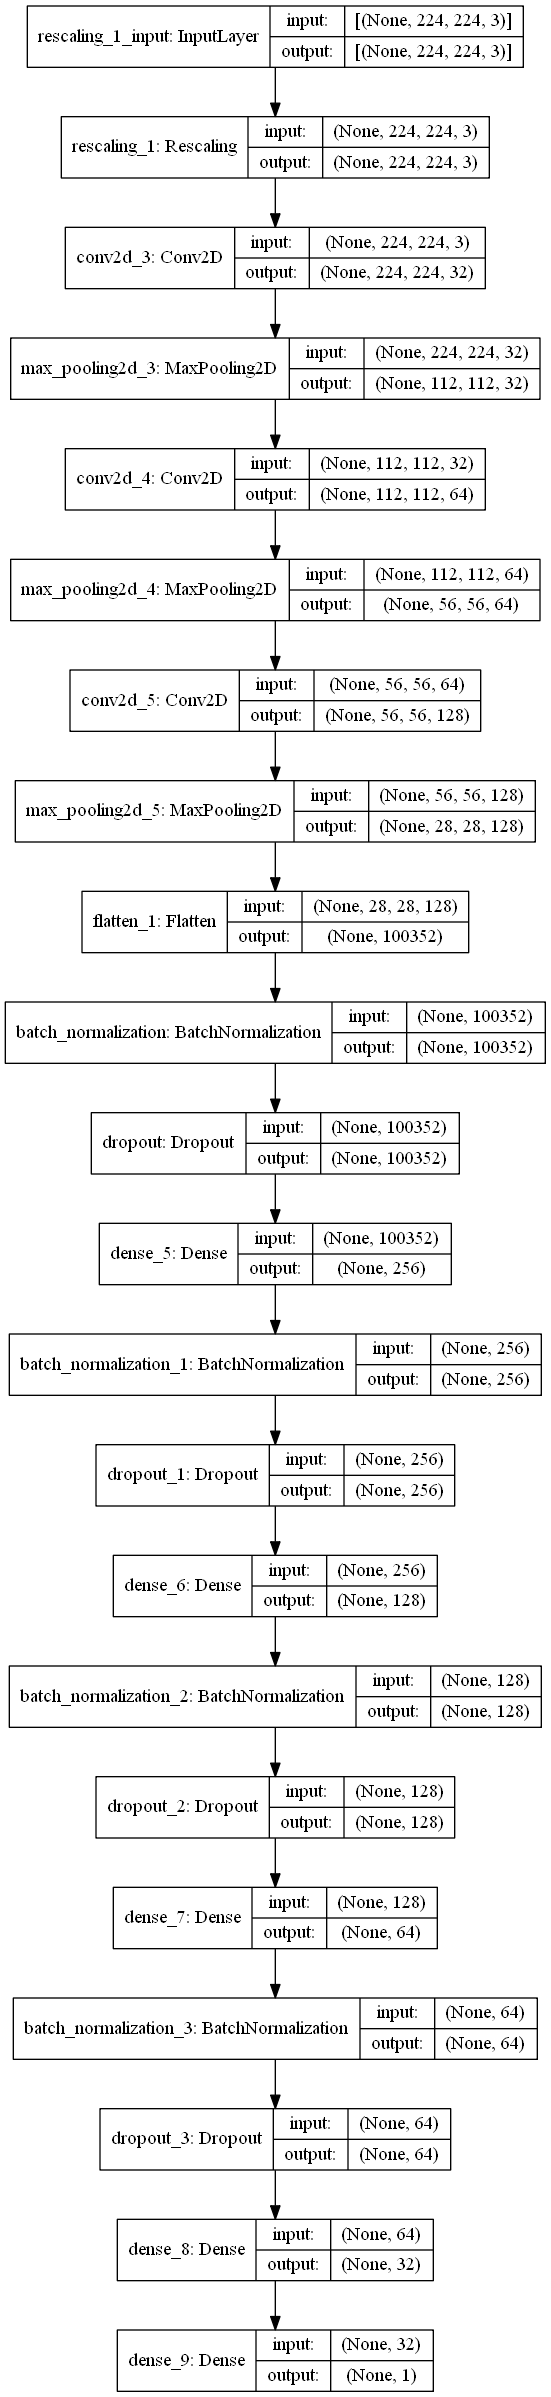

In [6]:
#show the result of architecture
keras.utils.plot_model(model2, show_shapes=True)

In [13]:
#summary model
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

We also using same optimizer, loss and metrics in this model with basic vanilla model. For the based model based on val loss also will be saved in svademodel format of tensorflow.

In [16]:
#Checkpoint definition
model2_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="./bestTunnedModel",
    save_weights_only = False,
    monitor = "val_loss",
    save_best_only=True
    )

#model compile
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss= "binary_crossentropy" , metrics=["accuracy", "AUC","Recall","Precision"])

In model training, we will using 10 epoch for all of model.

In [17]:
#train mdoel
history2 = model2.fit(
    X_train,
    validation_data= X_valid,
    epochs=10,
    verbose=2,
    callbacks=[model2_cp])

Epoch 1/10
726/726 - 420s - loss: 0.6417 - accuracy: 0.6378 - auc: 0.6783 - recall: 0.7910 - precision: 0.6336 - val_loss: 0.6020 - val_accuracy: 0.6597 - val_auc: 0.7452 - val_recall: 0.8715 - val_precision: 0.6396
INFO:tensorflow:Assets written to: .\bestTunnedModel\assets
Epoch 2/10
726/726 - 429s - loss: 0.6218 - accuracy: 0.6648 - auc: 0.7118 - recall: 0.7664 - precision: 0.6667 - val_loss: 0.6036 - val_accuracy: 0.6597 - val_auc: 0.7564 - val_recall: 0.9116 - val_precision: 0.6319
Epoch 3/10
726/726 - 430s - loss: 0.6121 - accuracy: 0.6801 - auc: 0.7211 - recall: 0.8009 - precision: 0.6728 - val_loss: 0.6350 - val_accuracy: 0.6895 - val_auc: 0.7461 - val_recall: 0.7299 - val_precision: 0.7120
Epoch 4/10
726/726 - 402s - loss: 0.6059 - accuracy: 0.6790 - auc: 0.7316 - recall: 0.7684 - precision: 0.6816 - val_loss: 1.1161 - val_accuracy: 0.6448 - val_auc: 0.7539 - val_recall: 0.9378 - val_precision: 0.6161
Epoch 5/10
726/726 - 440s - loss: 0.5964 - accuracy: 0.6921 - auc: 0.7403 - 

Below are the evaluation of its each epoch.

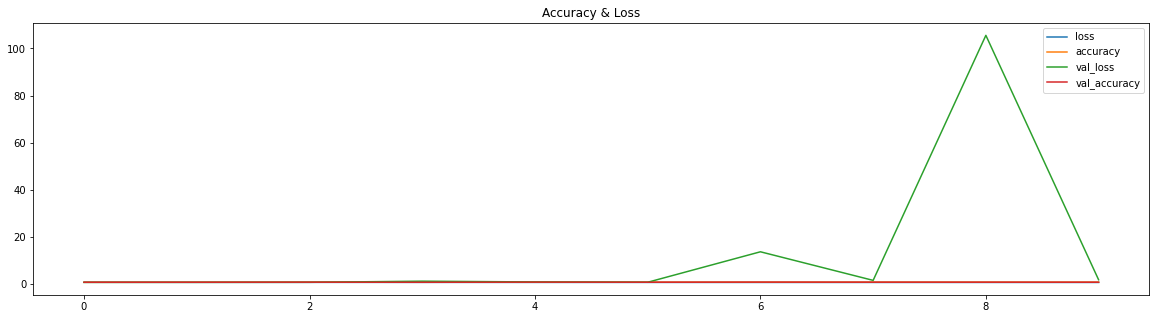

In [184]:
#Evaluation
hist2 = {k: history2.history[k] for k in ["loss","accuracy","val_loss","val_accuracy"]}

pd.DataFrame(hist2).plot(figsize=(20,5))
plt.title("Accuracy & Loss")
plt.show()

In the tunned version of our basic vanilla model, at first 5 epoch the validation loss and validation accuracy seems to have same value around 0,5 - 0,6. But starting epoch 6 , the validation loss seems increase significantly even at epoch 8 it reached 100. We could say, at 5 first epoch this model is perform stabil but got worse after that.

We've saved the best epoch weight which has the lowest validation loss between epoch to be our best version of this tunned model.

### Transfer-Learning Model

We've done classification model with vanilla approach before. Now, we will try using transfer-learning approach with pre-trained model called VGG19. Talking about  VGG19 , VGG19 is a CNN model which covered by 19 layers deep. This model has been pretrained on more than one million images from ImageNet Database and could classify images into 1000 objects. This model using images size 22x224 as its input.

In [ ]:
#Set random seed
tf.keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

We've know VGG19 can classifiy almost 1000 object . But in this case , we will only using its CNN layers (Feature extraction). For classification layer we will using our own neural network layers that's why include_top of this model will be disabled.
<br>
<br>

But before that, we need to define the VGG19 model first as our base model below.

In [8]:
#Base pre-trained model
base_model = vgg19.VGG19(include_top=False, weights="imagenet" , input_shape=(IMG_SIZE + (3,)))
base_model.trainable=False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now , we've got the feature extraction layer from our VGG19 model. Next, we will combine it with our classification layers. For this context, we will same classification layers with our tunned version of vanilla basic model.

In [9]:
## Build model ##

model3 = Sequential()

#Define CNN section
model3.add(layers.Rescaling(1./255, input_shape=(IMG_SIZE + (3,))))
model3.add(base_model)

#Define classification layer
model3.add(layers.Flatten())
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(rate=0.2))
model3.add(layers.Dense(256,activation="relu"))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(rate=0.2))
model3.add(layers.Dense(128,activation="relu"))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(rate=0.2))
model3.add(layers.Dense(64,activation="relu"))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(rate=0.2))
model3.add(layers.Dense(32,activation="relu"))
model3.add(layers.Dense(1, activation = "sigmoid"))

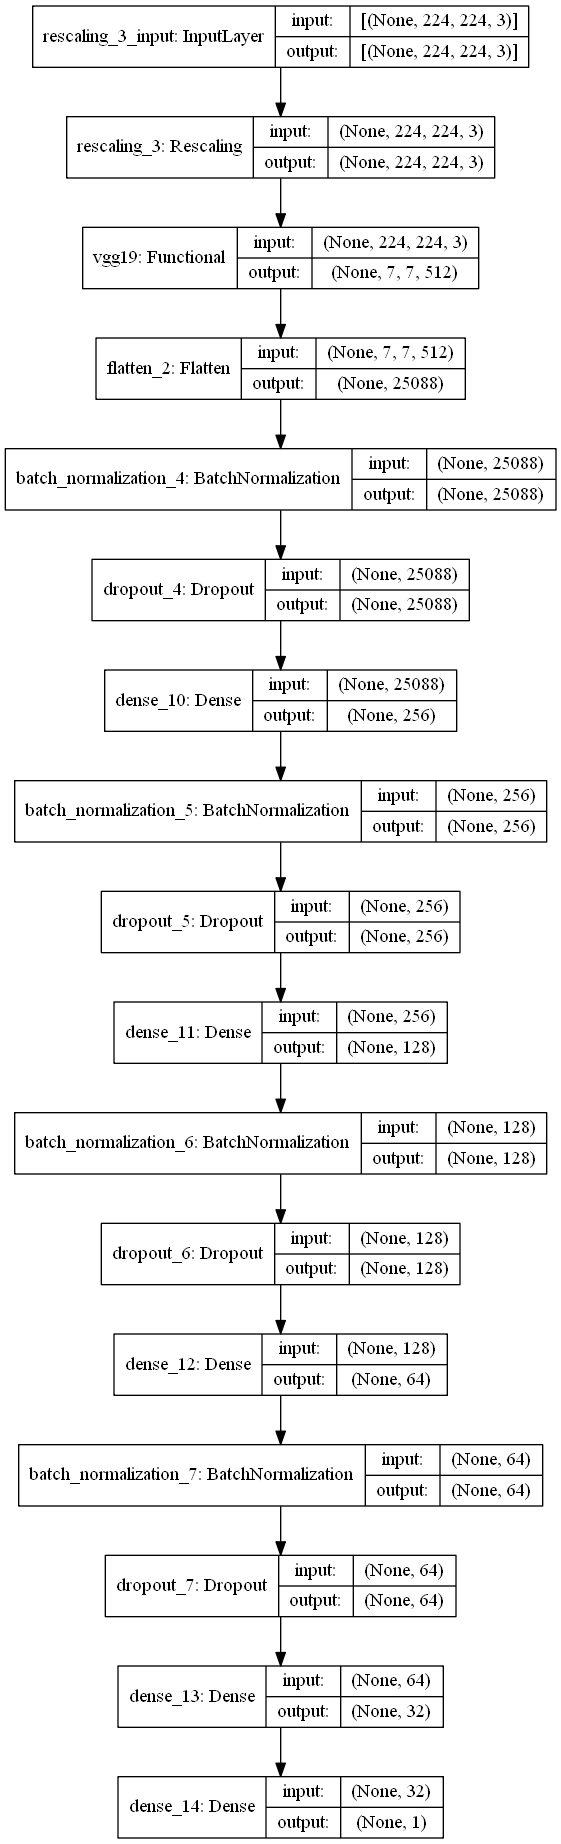

In [10]:
#show the result of architecture
keras.utils.plot_model(model3, show_shapes=True)

In [25]:
#model summary
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25088)             100352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

For optimization of this transfer-learning model approach, we will use same with other which Adam optimizer and same loss or metrics.

In [22]:
#Checkpoint definition
model3_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="./bestTransferedModel",
    save_weights_only = False,
    monitor = "val_loss",
    save_best_only=True
    )

#model compile
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss= "binary_crossentropy" , metrics=["accuracy", "AUC","Recall","Precision"])

In model training, we will using 10 epoch for all of model.

_Note: run this training will took long hours. Author tooks 8 hour to run it in without GPU_

In [26]:
#train mdoel
history3 = model3.fit(
    X_train,
    validation_data= X_valid,
    epochs=10,
    verbose=2,
    callbacks=[model3_cp])

Epoch 1/10
726/726 - 2518s - loss: 0.3363 - accuracy: 0.8551 - auc: 0.9300 - recall: 0.8947 - precision: 0.8472 - val_loss: 0.5155 - val_accuracy: 0.7943 - val_auc: 0.8873 - val_recall: 0.7339 - val_precision: 0.8713
Epoch 2/10
726/726 - 2588s - loss: 0.3067 - accuracy: 0.8708 - auc: 0.9424 - recall: 0.9039 - precision: 0.8646 - val_loss: 0.4589 - val_accuracy: 0.8064 - val_auc: 0.8867 - val_recall: 0.9157 - val_precision: 0.7735
INFO:tensorflow:Assets written to: .\bestTransferedModel\assets
Epoch 3/10
726/726 - 2835s - loss: 0.2862 - accuracy: 0.8780 - auc: 0.9498 - recall: 0.9112 - precision: 0.8704 - val_loss: 1.0651 - val_accuracy: 0.8058 - val_auc: 0.8743 - val_recall: 0.8534 - val_precision: 0.8049
Epoch 4/10
726/726 - 3051s - loss: 0.2543 - accuracy: 0.8951 - auc: 0.9604 - recall: 0.9193 - precision: 0.8911 - val_loss: 0.9993 - val_accuracy: 0.6983 - val_auc: 0.8699 - val_recall: 0.9869 - val_precision: 0.6480
Epoch 5/10
726/726 - 2502s - loss: 0.2449 - accuracy: 0.8967 - auc: 

Below are the evaluation of each epoch of the model.

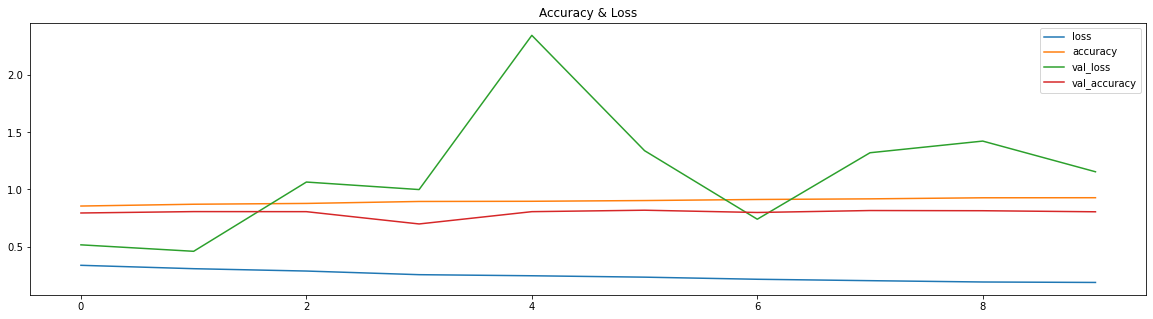

In [185]:
#Evaluation
hist3 = {k: history3.history[k] for k in ["loss","accuracy","val_loss","val_accuracy"]}

pd.DataFrame(hist3).plot(figsize=(20,5))
plt.title("Accuracy & Loss")
plt.show()

If at previous model we only got the accuracy around 0,5 , in this transfer learning model with VGG19 we got validation accuracy aroun 0,7 - 0,8 . It means the model getting better than before and seems little bit overfit but not flucuative. In the other hand, our validation loss looks so flucuative in 10 epoch. We've reached value 2 in loss as the worst between others.

We could conclude this transfer learning model seems good in accuracy but has bad loss value, but we've save the best weight of epoch which has the lowest validation loss than others.

## Model Evaluation

At previous session, we have tried create CNN model with 2 approach. First we've create basic CNN model with vanilla approach then we've tunned it with add some hyperparameter. And second, we've create CNN model with transfer-learning approach using pretrained model called VGG19.

We've also already saved each of model before and now in this section we will load each model to test it with our validation dataset. After that we will compare each valuation of each model to decide which model will be used in inference.

In [3]:
### Load each of previous model ###

#Basic sequential ANN model
bestBasic = tf.keras.models.load_model("bestBasicModel")

#Basic functional API ANN model
bestTunnedBasic = tf.keras.models.load_model("bestTunnedModel") 

#Tunned sequential ANN model
bestTransfer = tf.keras.models.load_model("bestTransferedModel")

In [37]:
#Evaluate each model
result =[]

for model in [bestBasic,bestTunnedBasic,bestTransfer]:
  res = model.evaluate(X_valid)
  result.append(res)

182/182 [==============================] - 453s 2s/step - loss: 0.4589 - accuracy: 0.8064 - auc: 0.8867 - recall: 0.9157 - precision: 0.7735


Below result are the evaluation of each model agains valid dataset. We will focusing on accuracy of model to choose the best model.

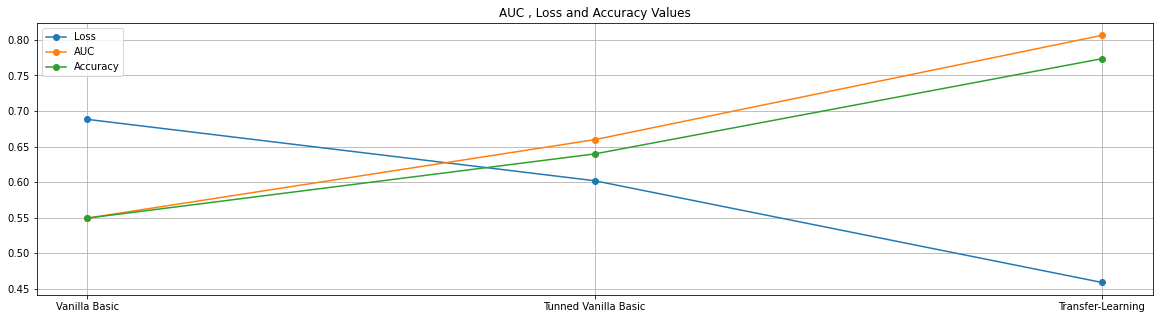

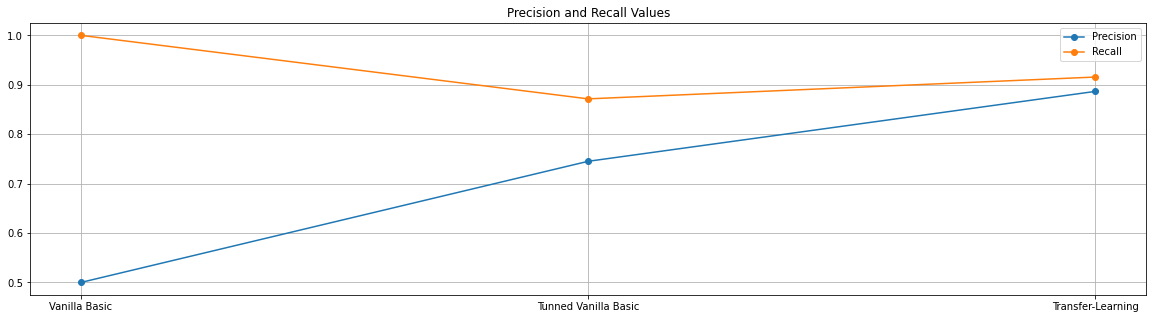

,Model,Loss,AUC,Precision,Recall,Accuracy
0,Vanilla Basic,0.688266,0.549366,0.500000,1.000000,0.549366
1,Tunned Vanilla Basic,0.601972,0.659680,0.745172,0.871486,0.639646
2,Transfer-Learning,0.458918,0.806398,0.886654,0.915663,0.773537


In [38]:
#Summary of evaluation
eval = pd.DataFrame([x for x in result], columns=["Loss","AUC","Precision","Recall","Accuracy"])
eval = pd.concat([pd.Series(["Vanilla Basic","Tunned Vanilla Basic","Transfer-Learning"], name = "Model"),eval], axis=1)

#Graph
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(eval['Model'],eval["Loss"], label="Loss", marker ="o")
plt.plot(eval['Model'],eval["AUC"], label="AUC", marker ="o")
plt.plot(eval['Model'],eval["Accuracy"], label="Accuracy", marker ="o")
plt.title("AUC , Loss and Accuracy Values")
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(eval['Model'],eval["Precision"], label="Precision", marker ="o")
plt.plot(eval['Model'],eval["Recall"], label="Recall", marker ="o")
plt.title("Precision and Recall Values")
plt.legend()
plt.show()

eval


From above graph, we could slightly see from 3 models we've tried before, the Transfer Learning model is the best one. 

Looking at the accuracy and AUC value which represent the ability of model to predict the class rightly, the graph is increasing as from model 1 to model 3. And also the validation loss, it's decreasing from model 1 to model 3. It means model 3 (Transfer Learning model) has the highest accuracy and AUC and the lowest validation loss.

At the other hand, if we see second paragraph we are expecting has high recall and precision values. But in this case,model 1 has highest recall but the lowest recall. That's why we've prefer to choose the most balanced precision vs recall which is at model 3. It has lowest precision and recall gap means this models more stabil.

We could conclude, the transfer learning using VGG19 is useful to help us to create better model . The model resulting the best result from any aspect of evaluation metrics eventhough it might be not stabil in each epoch. If author has a chance and enough computational resource in future, this model training might could be trained with more epoch to get the best result than now. So for now, we will choose model 3 (Transfer Learning Approach Model) to be our best model and used for model inference.

## Model Inference

For model inference, we will using the images in test folder. These models contains 20 images of happy expression and 20 images of sad expression. We will try to predict it and see what its result using our best model.

### Dataset Preparation

In [4]:
#Sample data path
sample1 = "test/happy/1174.jpg"
sample2 = "test/sad/22151.jpg"

In [5]:
#Getting the path of each image and its own label
path =[]
labels=[]
for label in os.listdir("test"):
  for images in os.listdir(str("test/"+label)):
    path.append(str("test/{}/{}".format(label,images)))
    labels.append(label)

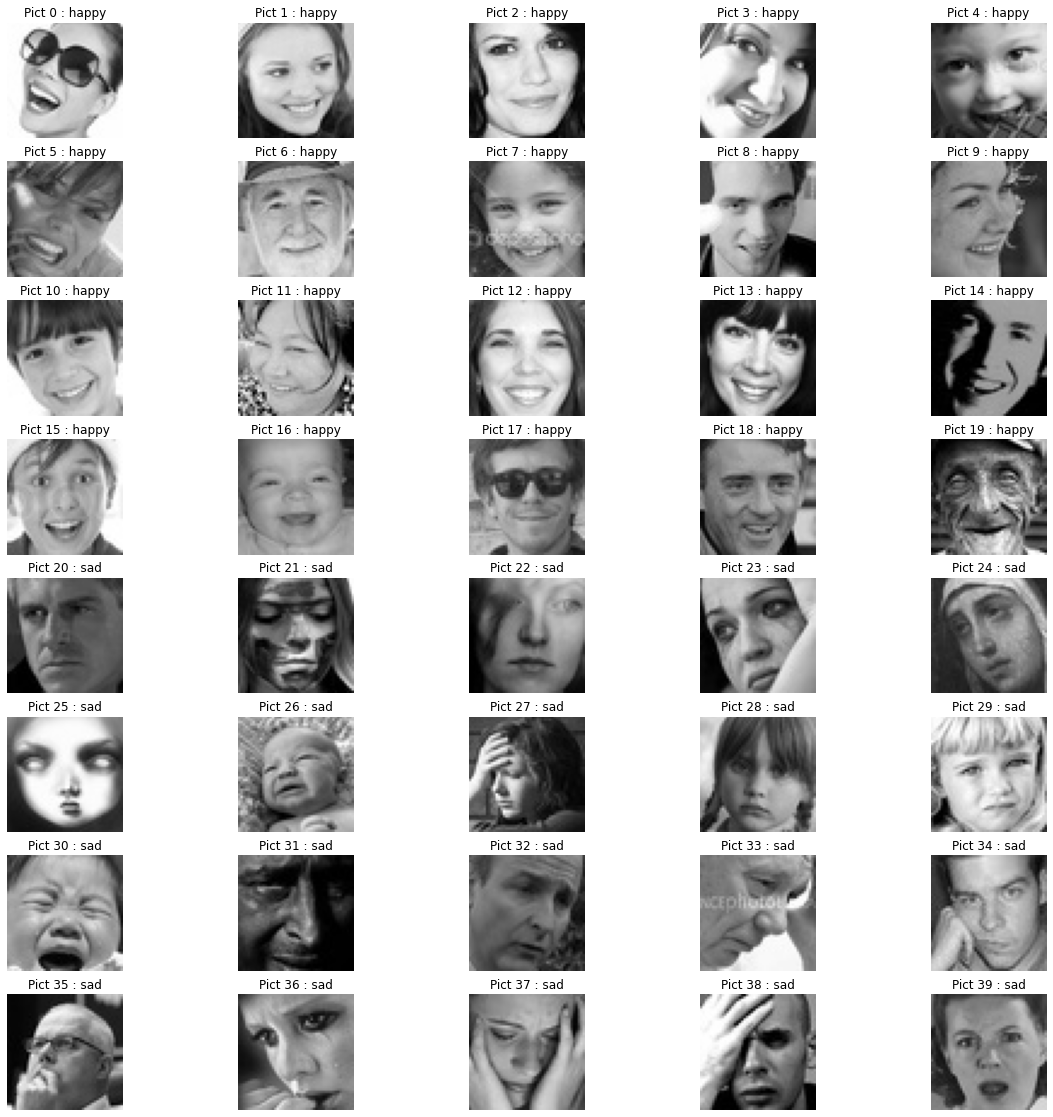

In [6]:
#Visualisasi dataset
plt.figure(figsize= (20,20))
for x,y,i in zip(path,labels,range(0,len(path))):
      ax = plt.subplot(8,5, i + 1)
      plt.imshow(load_img(x))
      plt.title("Pict {} : {}".format(i,y))
      plt.axis("off")

### Prediction

In [10]:
#Create prediction function
def prediction(path):
    img = img_to_array(load_img(path, target_size=(224,224)))
    arr = np.expand_dims(img, 0)
    pred = np.ravel((bestTransfer.predict(arr)>0.5).astype("int32"))
    return pred
    

In [11]:
#Predict the test dataset
pred_labels = []

for x in path:
  pred = prediction(x)
  for x in pred:
    if x == 1:
        pred_labels.append("sad")
    else:
        pred_labels.append("happy")

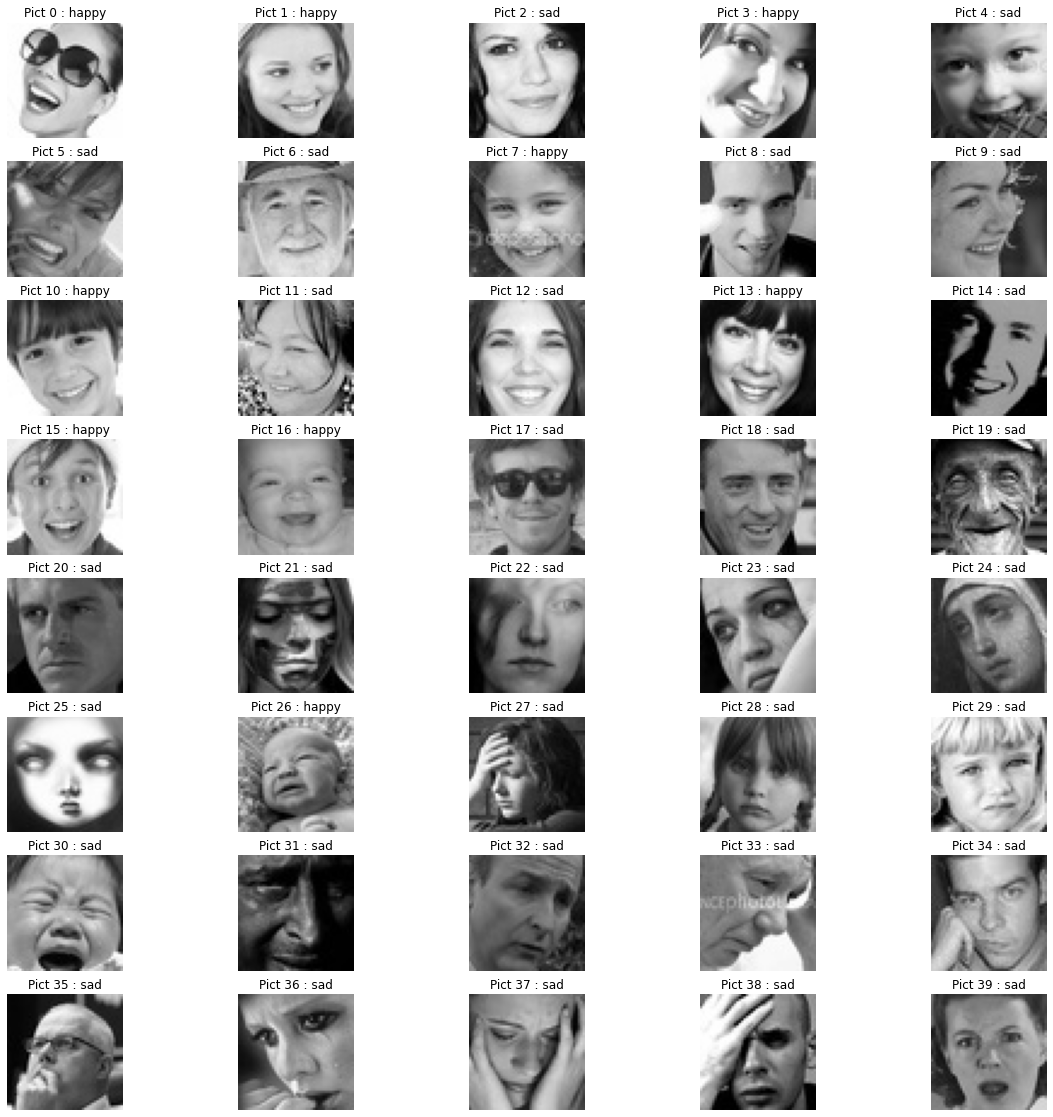

In [12]:
#Visualisasi prediction result
plt.figure(figsize= (20,20))
for x,y,i in zip(path,pred_labels,range(0,len(path))):
      ax = plt.subplot(8,5, i + 1)
      plt.imshow(load_img(x))
      plt.title("Pict {} : {}".format(i,y))
      plt.axis("off")

We could see the result, we got some correct prediction in test dataset but some of them goes wrong like picture number 2,5,9. It resulting sad instead of happy based on its picture. 

We might fine-tunning more in the future for the best result, either by add more epoch or event add more dataset training.

## Conclusion

Transfer learning using VGG19 is useful pre-trained model to help us to create better model . The model resulting the best result from any aspect of evaluation metrics eventhough it might be not stabil in each epoch. This model has accuracy ,recall and precision up to 0,8 which is better than model using vanilla approach. Not to mention because VGG19 has been trained on more than one million dataset ImageNet with almost 1000 class. If author has a chance and enough computational resource in future, this model training might could be trained with more epoch to get the best result than now.